## Summary
1. I use **three different ways** to predict return of AAPL and combine them toghter to give the final prediction. The Final result just include the first and the second one.
> 1. I fisrtly try to predict return by different models;   
> 2. Secondly, I predict stock price and use prediction to get predicted return. 
> 3. Finally, I use a classification model to predict the return.

3. Frankly speaking, the result is not good, but **I believe the bad result is right**. Because if the market is effective, we cannot predict the future in this simple way, and when we just give a stright line, its mse is smellest.
4. I focus on my thinking, my ideas and how I try to improve the models. Also, I try many different ways.



In [5]:
# import data and pakages
!git clone https://github.com/IrwinLai/Stock-Price-Prediction

import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, GRU, Bidirectional
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from datetime import datetime
import tensorflow as tf
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model


def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    return model

modelName = "test_model"
model_path = os.path.join(".", modelName)

fatal: destination path 'Stock-Price-Prediction' already exists and is not an empty directory.


In [17]:
DATA_PATH = "./Stock-Price-Prediction/data/final_project"
# try this one, if the path can not work ↓ 
# DATA_PATH = "./data/final_project" 

# a funtion to load AAPL data and create return
def Load_data(DATA_PATH):
    df = pd.read_csv( os.path.join(DATA_PATH, "AAPL.csv") )
    # delete duplications
    df = df.drop_duplicates()
    # get return
    df['return,t'] = df['Adj Close']/df['Adj Close'].shift(1) - 1
    return df
data = Load_data(DATA_PATH)
data.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,"return,t"
0,2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0,NaN
1,2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0,-0.084318
2,2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0,0.014630
3,2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0,-0.086546
4,2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0,0.047390


## Model1: Pridict AAPL's return directly
### case1: Only use AAPL's historical return data

### Split data into train and test
1. I only use the data after 2008. Because the big recession will confuse the machine to learn. And the can be trained quickly also.
2. I didn't suffle, just use the begining 10% as validation set, middle 70% as train set, and the last 20% as test set.

In [18]:
# this function can split data
def Data_Split(data, trainset_rate, aim_feature):
    trainlength = int(trainset_rate*len(data))

    # store base, because we need it to Destardize our output
    base = data[aim_feature][:trainlength].values.reshape(-1,1)
    # standardize return
    sc = MinMaxScaler(feature_range = (0, 1)).fit(base)
    # begining part is train set, ending part is test set
    train = sc.transform(data[aim_feature][:trainlength].values.reshape(-1,1))
    test = sc.transform(data[aim_feature][trainlength:].values.reshape(-1,1))


    for feature in list(data.columns):
        # standardize all features and split them 
        if (feature != aim_feature):
            sc = MinMaxScaler(feature_range = (0, 1)).fit(data[feature][:trainlength].values.reshape(-1,1))
            train = np.concatenate((train, sc.transform(data[feature][:trainlength].values.reshape(-1,1))), axis=1)
            test = np.concatenate((test, sc.transform(data[feature][trainlength:].values.reshape(-1,1))), axis=1)

    print("data aiming to {s} split done!\n".format(s = aim_feature))
    return train, test, base

data = pd.DataFrame(data['return,t'][2200:])
train, test, base = Data_Split(data, trainset_rate = 0.8, aim_feature = 'return,t')  


# this function can construct data to make sure it is 3-Dimensions
def Data_Construct(train, test, DATA_LENGTH, N): # DATA_LENGTH is using how many data to predict the next one, N is how many features

    x_train, y_train, x_test, y_test = [],[],[],[]
    for i in range(DATA_LENGTH, train.shape[0]):    # for train set
        x_train.append(train[i-DATA_LENGTH:i,0:N])  # [i-DATA_LENGTH:i] will be in x
        y_train.append(train[i,0])   # [i] will be the one after train, put it in y

    for i in range(DATA_LENGTH, test.shape[0]):   # for test set
        x_test.append(test[i-DATA_LENGTH:i,0:N])
        y_test.append(test[i,0])

    x_train = np.array(x_train)
    y_train = np.array(y_train).reshape(-1,1)
    x_test = np.array(x_test)
    y_test = np.array(y_test).reshape(-1,1)

    valid_size = x_train.shape[0] // 10    # set validation set
    x_valid = x_train[:valid_size]
    y_valid = y_train[:valid_size]
    x_train = x_train[valid_size:]
    y_train = y_train[valid_size:]

    print("x_train.shape: {a}, x_test.shape: {b}, x_valid.shape: {c}".format(a=x_train.shape, b=x_test.shape ,c=x_valid.shape)) 
    return x_train, y_train, x_test, y_test, x_valid ,y_valid


x_train, y_train, x_test, y_test, x_valid ,y_valid = Data_Construct(train, test, DATA_LENGTH=20, N=1)

data aiming to return,t split done!

x_train.shape: (1477, 20, 1), x_test.shape: (396, 20, 1), x_valid.shape: (164, 20, 1)


- Here, I just try to use 20 days to predict the next day.
- I find the more days I use, the loss will be smaller. But it takes more time, so I use 20 days.

## Model Interpretation
1. For activation, I use 'linear' not 'relu' to predict return. Because 'relu' are easily give '0' for result.
1. I set big Learning rate and small batch size at first. In that case, after setting model, I can decrease learning rate and enlarge batch size to find out the best parameters.
1. I tried diffent strcture of LSTM, and finally used 3 layers for 64,32,16 units in each layer, because this one works well.
1. The epoch number is large, I use callback to stop it.
1. For predicting return, I use "adam".

In [14]:
# this function can run LSTM model, given learning rate and batch size
def LSTM_Model(learn_rate=0.005, batch=64,opt="adam"):
    # three LSTM layers and dropout
    model = Sequential()
    model.add(LSTM(units = 64, return_sequences = True, input_shape = (x_train.shape[1],x_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 16, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation = "linear"))
    # call back
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.00003, patience=5, verbose=0, mode='auto', \
                                                  baseline=None, restore_best_weights=True)
    callbacks = [ es_callback, ModelCheckpoint(filepath=modelName + ".ckpt", monitor='val_loss', save_best_only=True)]

    # set learning rate
    if opt == "adam":
        opt = optimizers.Adam(learning_rate=learn_rate)
    elif opt == "rmsprop":
        opt = optimizers.RMSprop(learning_rate=learn_rate)
    model.compile(loss = 'mse', optimizer = opt)
    model.fit(x_train,y_train, epochs = 50,validation_data=(x_valid,y_valid), batch_size = batch, shuffle = False, callbacks=callbacks)
    return model

LSTM_RET1 = LSTM_Model(learn_rate=0.001, batch=64,opt="adam")

Train on 1494 samples, validate on 166 samples
Epoch 1/50
1494/1494 [==============================] - 5s 4ms/sample - loss: 0.2027 - val_loss: 0.1858
Epoch 2/50
1494/1494 [==============================] - 0s 230us/sample - loss: 0.1224 - val_loss: 0.0776
Epoch 3/50
1494/1494 [==============================] - 0s 221us/sample - loss: 0.0234 - val_loss: 0.0236
Epoch 4/50
1494/1494 [==============================] - 0s 223us/sample - loss: 0.0095 - val_loss: 0.0219
Epoch 5/50
1494/1494 [==============================] - 0s 219us/sample - loss: 0.0089 - val_loss: 0.0209
Epoch 6/50
1494/1494 [==============================] - 0s 194us/sample - loss: 0.0083 - val_loss: 0.0210
Epoch 7/50
1494/1494 [==============================] - 0s 228us/sample - loss: 0.0085 - val_loss: 0.0208
Epoch 8/50
1494/1494 [==============================] - 0s 212us/sample - loss: 0.0085 - val_loss: 0.0207
Epoch 9/50
1494/1494 [==============================] - 0s 220us/sample - loss: 0.0083 - val_loss: 0.0207
E

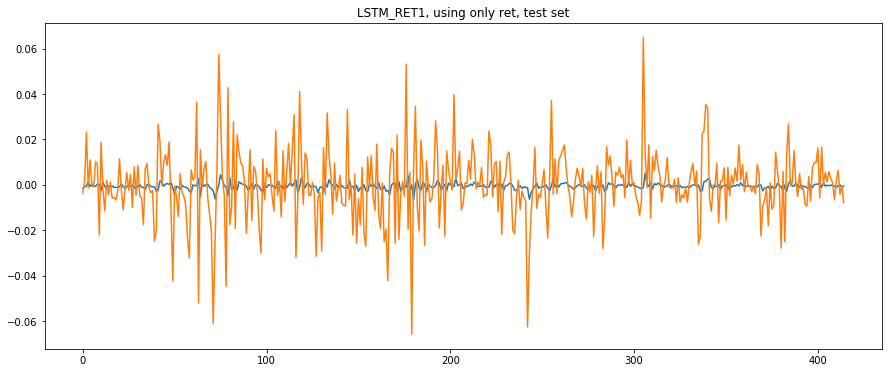

In test set, mse is 0.10230; In train set, mse is 0.42075


In [15]:
# this function is to output the prediction result and mse
def Test_Result(Model, x_train, x_test, y_train, y_test, base, try_train, title):
    sc = MinMaxScaler(feature_range = (0, 1)).fit(base)
    pre_ret = Model.predict(x_test)
    pre_ret = pd.Series(sc.inverse_transform(pre_ret).reshape(-1))
    y_ret = pd.Series(sc.inverse_transform(y_test).reshape(-1))
    tem = pre_ret-y_ret
    tem = tem.apply(lambda x:x**2)
    mse1 = sum(tem)
    plt.figure(figsize = (15, 6))
    plt.plot(pre_ret)
    plt.plot(y_ret)
    plt.title(title + ", test set")
    plt.show()

    
    pre_ret = Model.predict(x_train)
    pre_ret = pd.Series(sc.inverse_transform(pre_ret).reshape(-1))
    y_ret = pd.Series(sc.inverse_transform(y_train).reshape(-1))
    tem = pre_ret-y_ret
    tem = tem.apply(lambda x:x**2)
    mse2 = sum(tem)
    if try_train == True:
        plt.figure(figsize = (15, 6))
        plt.plot(pre_ret)
        plt.plot(y_ret)
        plt.title(title + ", train set")
        plt.show()

    print("In test set, mse is {a:5.5f}; In train set, mse is {b:5.5f}".format(a = mse1, b = mse2))

Test_Result(LSTM_RET1, x_train, x_test, y_train, y_test, base, try_train = False, title = "LSTM_RET1, using only ret")

## Comment:
1. From this picture, we can find that the model have learned mean of the historical return. Although, it is just like a straight line, I don't think it is a mistake, instead, it shows the market is effective.
2. I tried different days and parameters. sometimes the predict return looks volitile, but it actually has large mse.
3. It is because that 'mse' will give large punishment to large mistake. If the market is effective, to avoid large mistakes, the machine will not do prediction, just give a mean value, so the mse will be smallest.

## Feature Engineering
### Use AAPL's historical data to do feature engineering
1. Calendar effect: : week, month, day, weekday
2. Volatility factors: volatility, daily change
3. Momentum & Reversion factors: MA5, MA20, RSI
4. Alpha (I get some simple alpha from Worldquant Alpha)
5. Abnormal return: AAPL's return - SPY's return
6. I find High, Close, Open, Low will make the result bad, so I delete them.

In [19]:
# Feature Engineering by the AAPL's historical data
def Feature_Engineering(df,DATA_PATH="./Stock-Price-Prediction/data/final_project"):
    # get SPY and SPY's return
    df['SPY'] = pd.read_csv( os.path.join(DATA_PATH, "SPY.csv"))['Adj Close']
    df['return,spy'] = df['SPY']/df['SPY'].shift(1) - 1

    # calendar factors
    df['year'] = df.Dt.apply(lambda x:int(x.split('-')[0]))
    df['month'] = df.Dt.apply(lambda x:int(x.split('-')[1]))
    df['day'] = df.Dt.apply(lambda x:int(x.split('-')[2]))
    df['Dt'] = pd.to_datetime(df.Dt)
    df['weekday'] = df.Dt.apply(lambda x:x.weekday()+1)

    # volatility factors: volatility, daily change
    df['vol'] = np.log((df['return,t']+1)).rolling(21).std()
    df['daily_range1'] = df['High']/df['Low'] - 1
    df['daily_range2'] = df['Open']/df['Close'] - 1

    # momentum & reversion factors
    df['ma5'] = df['Adj Close'].rolling(5).mean()
    df['ma20'] = df['Adj Close'].rolling(20).mean()
    df['rise14'] = df['return,t'].apply(lambda x:max(x,0)).rolling(14).sum()
    df['fall14'] = df['return,t'].apply(lambda x:max(-x,0)).rolling(14).sum()
    df['RSI'] = df['rise14']/(df['rise14'] + df['fall14'])*100

    # Worldquant alpha
    df['beat_market'] = df['return,t'] - df['return,spy']
    df['Alpha1'] = -1*df['Adj Close'].rolling(10).corr(df['Volume'])
    df['Alpha2'] = -1*(df['Low'] - df['Close'])*df['Open']**5/((df['Low'] - df['High'])*df['Close']**5+0.01)
    df['Aplha3'] = -1*((df['Close'] - df['Low']) - (df['High'] - df['Close']))/(df['Close'] - df['Low']+0.01)
    df['Aplha3'] = df['Aplha3'].shift(9)

    # rename columns
    del df['Factor'],df['Close'],df['Div'],df['rise14'],df['fall14'],df['High'],df['Open'],\
                  df['Low'],df['Dt'],df['return,spy'],df['SPY']

    return df

data = Load_data(DATA_PATH)
data = Feature_Engineering(data,DATA_PATH)
data = data[2200:]
data.head(5)

,Adj Close,Volume,"return,t",year,month,day,weekday,vol,daily_range1,daily_range2,ma5,ma20,RSI,beat_market,Alpha1,Alpha2,Aplha3
2200,12.4424,402341100.0,-0.082662,2008,10,2,4,0.059005,0.087900,0.079021,13.83160,16.662175,27.478217,-0.046388,0.632750,-0.016640,-0.284165
2201,12.0658,573599600.0,-0.030267,2008,10,3,5,0.058974,0.125198,0.071392,13.05672,16.269945,28.452460,-0.016767,0.813592,-0.288296,22.025000
2202,12.1988,526854300.0,0.011023,2008,10,6,1,0.059356,0.128398,-0.062971,12.87972,15.898410,29.590264,0.061957,0.808726,-0.681246,46.210526
2203,11.0826,469693000.0,-0.091501,2008,10,7,2,0.061375,0.141091,0.126963,12.27064,15.509850,29.388113,-0.046715,0.760408,-0.030417,-0.369748
2204,11.1609,551935300.0,0.007065,2008,10,8,3,0.061739,0.124300,-0.043190,11.79010,15.125640,25.401134,0.032258,0.740049,-0.309472,-0.160819


data aiming to return,t split done!

x_train.shape: (1477, 20, 17), x_test.shape: (396, 20, 17), x_valid.shape: (164, 20, 17)
Train on 1477 samples, validate on 164 samples
Epoch 1/50
1477/1477 [==============================] - 10s 7ms/sample - loss: 0.0278 - val_loss: 0.0183
Epoch 2/50
1477/1477 [==============================] - 3s 2ms/sample - loss: 0.0094 - val_loss: 0.0145
Epoch 3/50
1477/1477 [==============================] - 3s 2ms/sample - loss: 0.0078 - val_loss: 0.0142
Epoch 4/50
1477/1477 [==============================] - 3s 2ms/sample - loss: 0.0076 - val_loss: 0.0164
Epoch 5/50
1477/1477 [==============================] - 3s 2ms/sample - loss: 0.0079 - val_loss: 0.0158
Epoch 6/50
1477/1477 [==============================] - 3s 2ms/sample - loss: 0.0075 - val_loss: 0.0140
Epoch 7/50
1477/1477 [==============================] - 3s 2ms/sample - loss: 0.0062 - val_loss: 0.0140
Epoch 8/50
1477/1477 [==============================] - 3s 2ms/sample - loss: 0.0065 - val_loss: 0

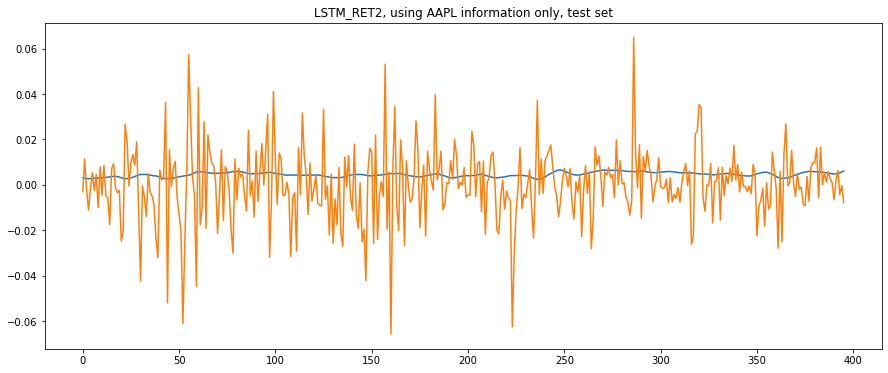

In test set, mse is 0.10805; In train set, mse is 0.43122


In [20]:
# split data, construct input for LSTM and train model
train, test, base = Data_Split(data, trainset_rate = 0.8, aim_feature = 'return,t') 
x_train, y_train, x_test, y_test, x_valid ,y_valid = Data_Construct(train, test, DATA_LENGTH=20, N=len(data.columns))
LSTM_RET2 = LSTM_Model(learn_rate=0.005, batch=64)
Test_Result(LSTM_RET2, x_train, x_test, y_train, y_test, base, try_train = False,title = "LSTM_RET2, using AAPL information only")

### Comment
1. It seems similar in result, but in validation set, it improves a little. So the feature engineering may works.

### Case3: Use other stocks and ETF to do feature engineering
1. First, I only consider the stocks which have data on 2008. Some stocks didn't get list on 2008 like facebook, it would cause problems if I add it into data set.
2. I use the correlation matrix and Random Forest to judge which stock is valuable to be added in. But the result show they are similar, so I add all of the stock which has data after 2008.
3. To build a Random Forest, I need to turn this problem into a classification problem. So, I divide the return into 8 types to represent different kind of return. I will also use this funtion in later part.

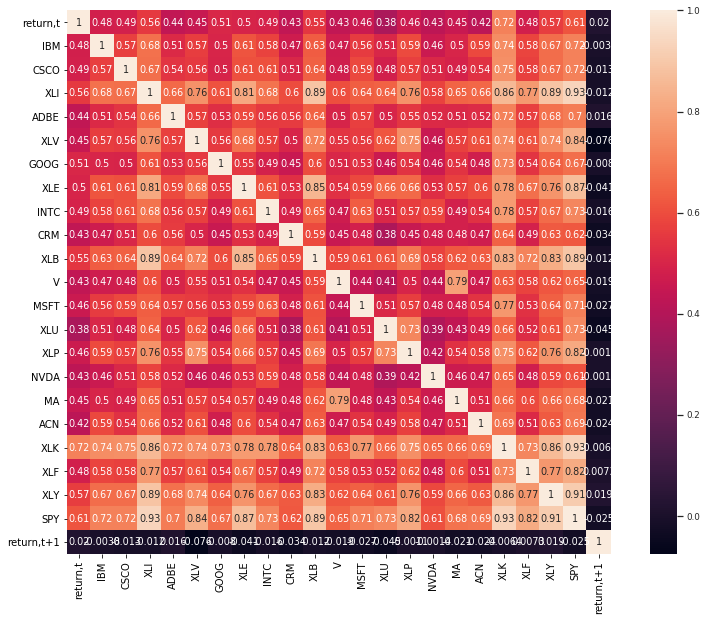

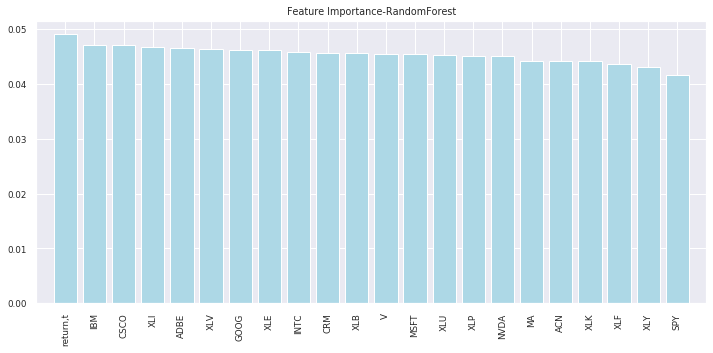

In [21]:
# this funtion can turn return into categorical data. There are 9 types.
def tran_class(ret):
    if ret < -0.04: return 0
    elif ret < -.02: return 1
    elif ret < -.008: return 2
    elif ret < -.002: return 3
    elif ret < 0.002: return 4
    elif ret < 0.008: return 5
    elif ret < 0.02: return 6
    elif ret < 0.04: return 7
    else: return 8

# get all the stocks data's return
data = Load_data(DATA_PATH)
stocks = pd.DataFrame(data['return,t'])
files= os.listdir(DATA_PATH) 
for file in files:
    if file != 'AAPL.csv':
        name = file.split('.')[0]
        tem = pd.read_csv( os.path.join(DATA_PATH, file))['Adj Close']
        tem = tem/tem.shift(1) - 1
        # only the stock has data on 2008 can be added in
        if len(tem.dropna()) >= len(stocks[2200:]):
            stocks[name] = tem
# the next day's return will be y
stocks["return,t+1"] = stocks["return,t"].shift(-1)
stocks = stocks[2200:]
stocks.head()

#correlation matrix
corrmat = stocks.corr()
f, ax = plt.subplots(figsize=(14, 10))
sns.set(font_scale=0.8)
sns.heatmap(corrmat, annot = True, vmax=1, square=True);

# split data into x and y to build Random Forest model
temy = (stocks['return,t+1'].dropna()).apply(lambda x:tran_class(x))
temx = (stocks.dropna()).copy()
del temx['return,t+1']
feat_labels = temx.columns[:]
forest = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=0)
forest.fit(temx,temy)

# print importance
importances = forest.feature_importances_
indices=np.argsort(importances)[::-1]
# print photo
f, ax = plt.subplots(figsize=(10, 5))
plt.title('Feature Importance-RandomForest')
plt.bar(range(temx.shape[1]),importances[indices],color='lightblue',align='center')
plt.xticks(range(temx.shape[1]),feat_labels,rotation=90)
plt.xlim([-1,temx.shape[1]])
plt.tight_layout()
plt.show()

### Comment:
1. The correlation matrix shows that every stock has positve relationship with Apple's return. But if I take a lag, every stocks has almost 0 relationship with the next day's Apple's return.
2. According to the importance photo, every stock has similar importance.
3. I find these two ways cannot judge which stocks is better in predicting Apple's return. So I will add all stocks, which have data after 2008, into data. there are 21 stocks.


In [22]:
# this funtion can add the stocks data
def ADD_STOCKS(df):
    files= os.listdir(DATA_PATH) 
    for file in files:
        if file != 'AAPL.csv':
            name = file.split('.')[0]
            tem = pd.read_csv(os.path.join(DATA_PATH, file))['Adj Close']
            # only the stock has data on 2008 can be added in
            if len(tem.dropna()) >= len(df[2200:]):
                df[name] = tem
    return df

data = Load_data(DATA_PATH)
data = Feature_Engineering(data,DATA_PATH)
data = ADD_STOCKS(data)
data = data[2200:]
data.head()

,Adj Close,Volume,"return,t",year,month,day,weekday,vol,daily_range1,daily_range2,ma5,ma20,RSI,beat_market,Alpha1,Alpha2,Aplha3,IBM,CSCO,XLI,ADBE,XLV,GOOG,XLE,INTC,CRM,XLB,V,MSFT,XLU,XLP,NVDA,MA,ACN,XLK,XLF,XLY,SPY
2200,12.4424,402341100.0,-0.082662,2008,10,2,4,0.059005,0.087900,0.079021,13.83160,16.662175,27.478217,-0.046388,0.632750,-0.016640,-0.284165,74.7851,16.5319,22.3273,35.22,25.0203,194.5159,45.3402,12.1036,11.0475,23.7586,11.4820,20.1203,21.5644,20.3079,8.5986,15.0661,28.4858,15.7599,10.0072,22.7553,89.2205
2201,12.0658,573599600.0,-0.030267,2008,10,3,5,0.058974,0.125198,0.071392,13.05672,16.269945,28.452460,-0.016767,0.813592,-0.288296,22.025000,73.8569,16.5709,21.9719,33.69,24.4836,192.7326,44.7996,12.1810,10.3925,23.5248,11.3325,20.1740,21.2404,20.1452,8.3221,15.0726,27.4634,15.5348,9.5690,21.9598,88.0160
2202,12.1988,526854300.0,0.011023,2008,10,6,1,0.059356,0.128398,-0.062971,12.87972,15.898410,29.590264,0.061957,0.808726,-0.681246,46.210526,71.8434,15.9548,21.3953,30.71,23.5670,184.9119,42.3901,11.9136,10.1000,22.3638,11.0414,19.0932,20.2022,19.5607,7.2346,15.7510,26.5347,14.6759,9.0697,21.3421,83.5330
2203,11.0826,469693000.0,-0.091501,2008,10,7,2,0.061375,0.141091,0.126963,12.27064,15.509850,29.388113,-0.046715,0.760408,-0.030417,-0.369748,68.2947,14.6915,20.6845,28.69,22.9972,172.3590,40.0656,11.2732,8.9850,21.2105,10.1980,17.8055,19.3756,18.9393,6.6725,14.9315,24.9114,13.9254,8.1118,19.9712,79.7919
2204,11.1609,551935300.0,0.007065,2008,10,8,3,0.061739,0.124300,-0.043190,11.79010,15.125640,25.401134,0.032258,0.740049,-0.309472,-0.160819,64.6533,14.3016,20.3686,30.00,22.5844,168.4237,40.8224,11.4351,9.1250,21.8962,10.4931,17.6369,19.0383,18.4214,6.8107,15.4014,25.3712,13.8003,7.7857,19.5819,77.7817


data aiming to return,t split done!

x_train.shape: (1477, 20, 38), x_test.shape: (396, 20, 38), x_valid.shape: (164, 20, 38)
Train on 1477 samples, validate on 164 samples
Epoch 1/50
1477/1477 [==============================] - 11s 8ms/sample - loss: 0.0251 - val_loss: 0.0165
Epoch 2/50
1477/1477 [==============================] - 4s 2ms/sample - loss: 0.0090 - val_loss: 0.0152
Epoch 3/50
1477/1477 [==============================] - 4s 2ms/sample - loss: 0.0080 - val_loss: 0.0140
Epoch 4/50
1477/1477 [==============================] - 4s 2ms/sample - loss: 0.0069 - val_loss: 0.0149
Epoch 5/50
1477/1477 [==============================] - 4s 2ms/sample - loss: 0.0070 - val_loss: 0.0142
Epoch 6/50
1477/1477 [==============================] - 4s 2ms/sample - loss: 0.0069 - val_loss: 0.0143
Epoch 7/50
1477/1477 [==============================] - 4s 2ms/sample - loss: 0.0068 - val_loss: 0.0140
Epoch 8/50
1477/1477 [==============================] - 5s 3ms/sample - loss: 0.0059 - val_loss: 0

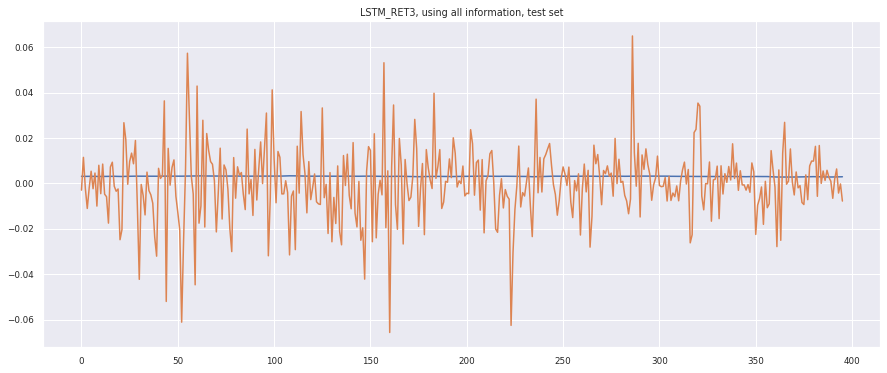

In test set, mse is 0.10392; In train set, mse is 0.41327


In [23]:
# split data, construct input for LSTM and train model
train, test, base = Data_Split(data, trainset_rate = 0.8, aim_feature = 'return,t') 
x_train, y_train, x_test, y_test, x_valid ,y_valid = Data_Construct(train, test, DATA_LENGTH=20, N=len(data.columns))

LSTM_RET3 = LSTM_Model(learn_rate=0.005, batch=64)

Test_Result(LSTM_RET3, x_train, x_test, y_train, y_test, base, try_train = False,title = "LSTM_RET3, using all information")

### Comment
- From the result, this model improves a little in validation set and train set. (Although the mse in test is similar to preivous one) So I think the feature engineer works.

### Try other models: GRU, Bidirectional LSTM
- GRU is also a kind of RNN, the difference between LSTM is that it has only two doors so it can be trained faster, and the result is simiar to LSTM.
- Bidirectional LSTM is a kind of LSTM consider two direction of data. It will train model by the data from begining to ending as well as from ending to begining.

data aiming to return,t split done!

x_train.shape: (1477, 20, 38), x_test.shape: (396, 20, 38), x_valid.shape: (164, 20, 38)
Train on 1477 samples, validate on 164 samples
Epoch 1/50
1477/1477 [==============================] - 12s 8ms/sample - loss: 0.1147 - val_loss: 0.0841
Epoch 2/50
1477/1477 [==============================] - 3s 2ms/sample - loss: 0.0315 - val_loss: 0.0142
Epoch 3/50
1477/1477 [==============================] - 3s 2ms/sample - loss: 0.0158 - val_loss: 0.0141
Epoch 4/50
1477/1477 [==============================] - 3s 2ms/sample - loss: 0.0130 - val_loss: 0.0232
Epoch 5/50
1477/1477 [==============================] - 3s 2ms/sample - loss: 0.0121 - val_loss: 0.0202
Epoch 6/50
1477/1477 [==============================] - 3s 2ms/sample - loss: 0.0115 - val_loss: 0.0149
Epoch 7/50
1477/1477 [==============================] - 3s 2ms/sample - loss: 0.0104 - val_loss: 0.0300
Epoch 8/50
1477/1477 [==============================] - 4s 3ms/sample - loss: 0.0130 - val_loss: 0

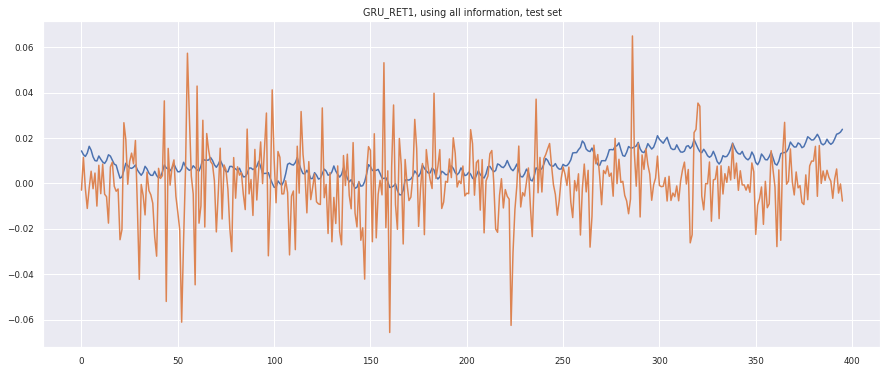

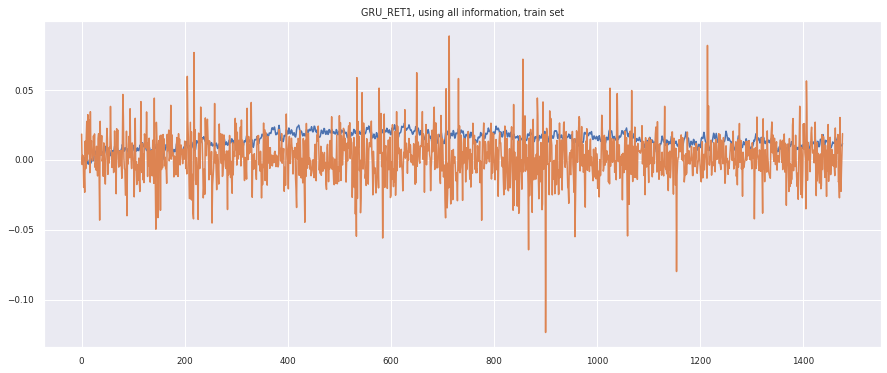

In test set, mse is 0.13601; In train set, mse is 0.69584


In [24]:
# load data
data = Load_data(DATA_PATH)
data = Feature_Engineering(data)
data = ADD_STOCKS(data)
data = data[2200:]
train, test, base = Data_Split(data, trainset_rate = 0.8, aim_feature = 'return,t') 
x_train, y_train, x_test, y_test, x_valid ,y_valid = Data_Construct(train, test, DATA_LENGTH=20, N=len(data.columns))

# this function can run GRU model, given learning rate and batch size
def GRU_Model(learn_rate=0.001, batch=64,opt="adam"):
    # three GRU layers and dropout
    model = Sequential()
    model.add(GRU(units = 64, return_sequences = True, input_shape = (x_train.shape[1],x_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(GRU(units = 32, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(GRU(units = 16, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation = "linear"))
    # call back
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.00003, patience=5, verbose=0, mode='auto', \
                                                  baseline=None, restore_best_weights=True)
    callbacks = [ es_callback, ModelCheckpoint(filepath=modelName + ".ckpt", monitor='val_loss', save_best_only=True)]

    # set learning rate
    if opt == "adam":
        opt = optimizers.Adam(learning_rate=learn_rate)
    elif opt == "rmsprop":
        opt = optimizers.RMSprop(learning_rate=learn_rate)
    model.compile(loss = 'mse', optimizer = opt)
    model.fit(x_train,y_train, epochs = 50,validation_data=(x_valid,y_valid), batch_size = batch, shuffle = False, callbacks=callbacks)

    return model

GRU_RET1 = GRU_Model(learn_rate=0.005, batch=64,opt="adam")
Test_Result(GRU_RET1, x_train, x_test, y_train, y_test, base, try_train = True,title = "GRU_RET1, using all information")

- Comment
It seems can not work (in different parameters, I tried). The result is worse.

data aiming to return,t split done!

x_train.shape: (1477, 20, 38), x_test.shape: (396, 20, 38), x_valid.shape: (164, 20, 38)
Train on 1477 samples, validate on 164 samples
Epoch 1/50
1477/1477 [==============================] - 32s 21ms/sample - loss: 0.0613 - val_loss: 0.0213
Epoch 2/50
1477/1477 [==============================] - 7s 5ms/sample - loss: 0.0085 - val_loss: 0.0151
Epoch 3/50
1477/1477 [==============================] - 7s 5ms/sample - loss: 0.0076 - val_loss: 0.0164
Epoch 4/50
1477/1477 [==============================] - 8s 5ms/sample - loss: 0.0081 - val_loss: 0.0176
Epoch 5/50
1477/1477 [==============================] - 7s 5ms/sample - loss: 0.0079 - val_loss: 0.0143
Epoch 6/50
1477/1477 [==============================] - 7s 5ms/sample - loss: 0.0065 - val_loss: 0.0156
Epoch 7/50
1477/1477 [==============================] - 8s 5ms/sample - loss: 0.0064 - val_loss: 0.0142
Epoch 8/50
1477/1477 [==============================] - 7s 5ms/sample - loss: 0.0061 - val_loss: 

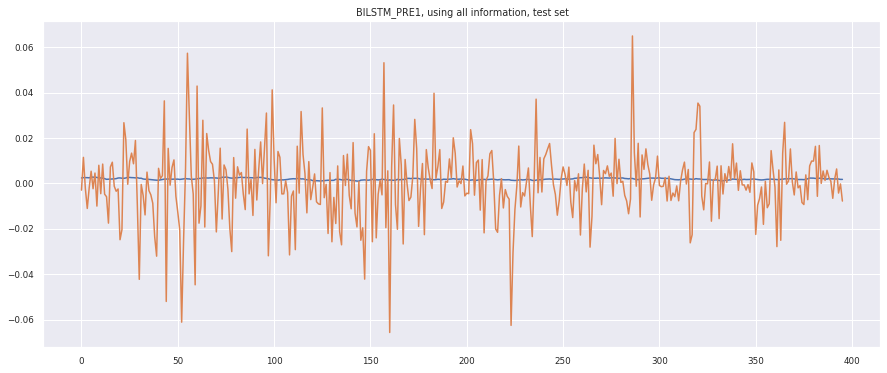

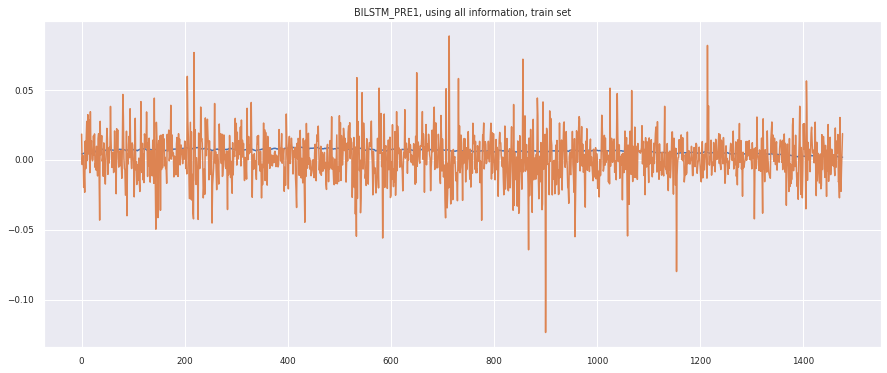

In test set, mse is 0.10097; In train set, mse is 0.44830


In [30]:
# this function can run Bidirectional LSTM model, given learning rate and batch size
def BILSTM_Model(learn_rate=0.001, batch=64,opt="adam"):
    # three Bidirectional LSTM layers and dropout
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 64, return_sequences = True, input_shape = (x_train.shape[1],x_train.shape[2]))))
    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(units = 32, return_sequences = True)))
    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(units = 16, return_sequences = False)))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation = "linear"))
    # call back
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.00003, patience=5, verbose=0, mode='auto', \
                                                  baseline=None, restore_best_weights=True)
    callbacks = [ es_callback, ModelCheckpoint(filepath=modelName + ".ckpt", monitor='val_loss', save_best_only=True)]

    # set learning rate
    if opt == "adam":
        opt = optimizers.Adam(learning_rate=learn_rate)
    elif opt == "rmsprop":
        opt = optimizers.RMSprop(learning_rate=learn_rate)
    model.compile(loss = 'mse', optimizer = opt)
    model.fit(x_train,y_train, epochs = 50,validation_data=(x_valid,y_valid), batch_size = batch, shuffle = False, callbacks=callbacks)
    return model

# load data
data = Load_data(DATA_PATH)
data = Feature_Engineering(data)
data = ADD_STOCKS(data)
data = data[2200:]
train, test, base = Data_Split(data, trainset_rate = 0.8, aim_feature = 'return,t') 
x_train, y_train, x_test, y_test, x_valid ,y_valid = Data_Construct(train, test, DATA_LENGTH=20, N=len(data.columns))

BILSTM_PRE1 = BILSTM_Model(learn_rate=0.005, batch=64,opt="adam")
Test_Result(BILSTM_PRE1, x_train, x_test, y_train, y_test, base, try_train = True,title = "BILSTM_PRE1, using all information")

- Comment
1. It has similar result to LSTM, but in train and validation set, LSTM one is better.
1. Both GRU and Bidirectional LSTM's results are not better than LSTM, so I just use previous LSTM model.

### Change learning rate and batch size
I change the learning rate and batch size, but I find the initialized one is just the best. So I will use that one with 0.005 learning rate and 64 batchsize

In [31]:
# Save my first model
modelName = "ret_model"
model_path = os.path.join(".", modelName)
saveModel(LSTM_RET3, model_path)

Model saved in directory ./ret_model; create an archive of this directory and submit with your assignment.


# Predict return indirectly
## Predict Price
1. First predict the price, and then we can use the price to get the return.
1. Price has special pattern, it may be easier to predict.
3. I use activation "rmsprop", because this one can track the pattern, so it is more used in price prediction.
4. I just focus on the return's mse, sometimes the prices predition looks bad, but return is good. that is because the model learns the patten.

data aiming to Adj Close split done!

x_train.shape: (1477, 20, 17), x_test.shape: (396, 20, 17), x_valid.shape: (164, 20, 17)
Train on 1477 samples, validate on 164 samples
Epoch 1/50
1477/1477 [==============================] - 14s 9ms/sample - loss: 0.0809 - val_loss: 0.2797
Epoch 2/50
1477/1477 [==============================] - 4s 2ms/sample - loss: 0.0236 - val_loss: 0.1747
Epoch 3/50
1477/1477 [==============================] - 4s 2ms/sample - loss: 0.0180 - val_loss: 0.7474
Epoch 4/50
1477/1477 [==============================] - 4s 3ms/sample - loss: 0.0441 - val_loss: 0.1113
Epoch 5/50
1477/1477 [==============================] - 4s 3ms/sample - loss: 0.0132 - val_loss: 0.0882
Epoch 6/50
1477/1477 [==============================] - 4s 3ms/sample - loss: 0.0132 - val_loss: 0.0585
Epoch 7/50
1477/1477 [==============================] - 4s 3ms/sample - loss: 0.0095 - val_loss: 0.0372
Epoch 8/50
1477/1477 [==============================] - 4s 2ms/sample - loss: 0.0091 - val_loss: 

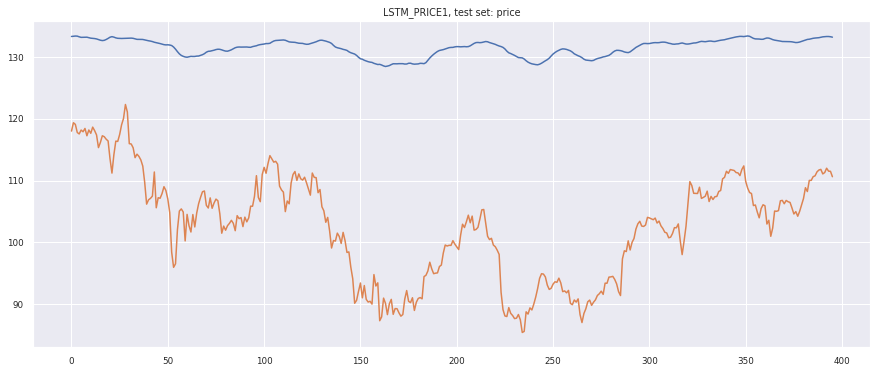

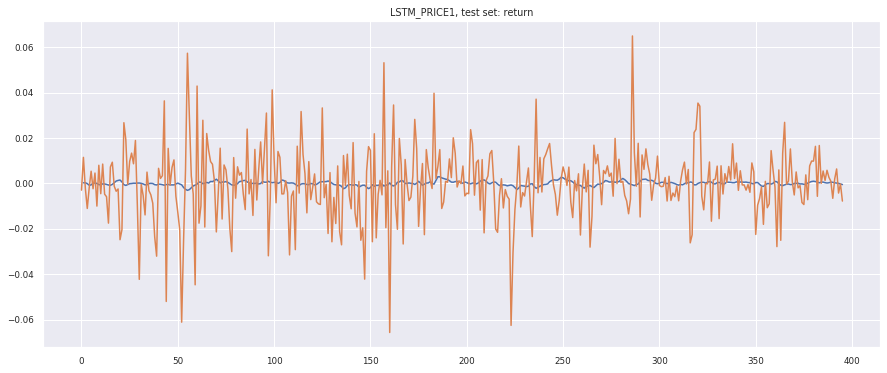

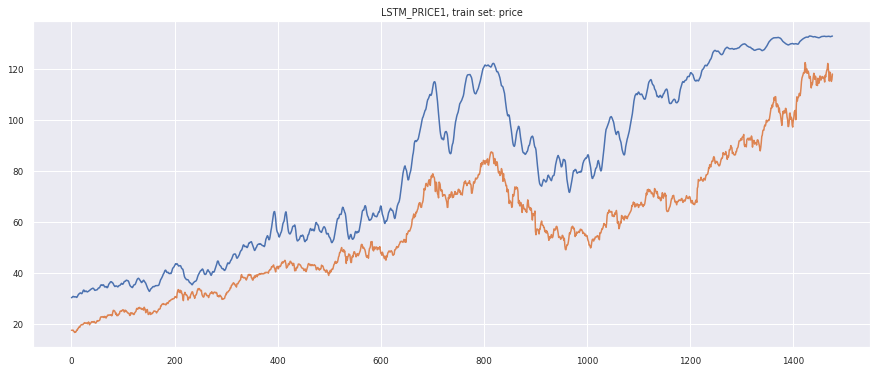

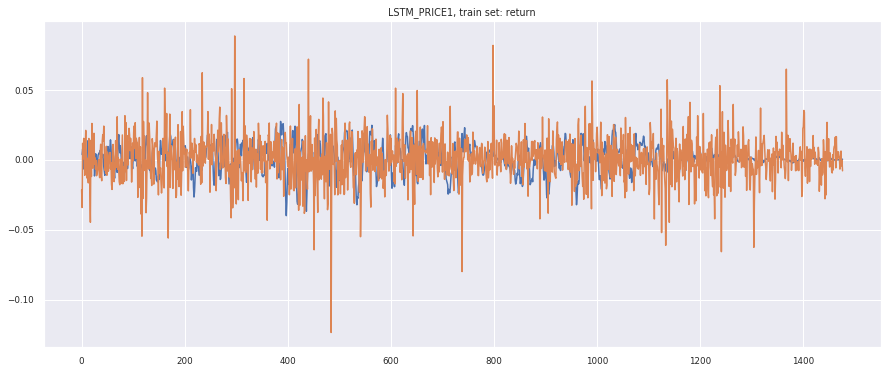

In test set, mse is 0.10104; In train set, mse is 0.53152


In [25]:
# load data
data = Load_data(DATA_PATH)
data = Feature_Engineering(data)
data = data[2200:]
data.head()

# split data into train and test
train, test, base = Data_Split(data, trainset_rate = 0.8, aim_feature = 'Adj Close') 
x_train, y_train, x_test, y_test, x_valid ,y_valid = Data_Construct(train, test, DATA_LENGTH=20, N=len(data.columns))

# train the model
LSTM_PRICE1 = LSTM_Model(learn_rate=0.005, batch=64,opt="rmsprop")

# this function is to output the prediction of price result and mse
def Test_Result_PRICE(Model, data, x_train, x_test, y_train, y_test, base, try_train, title):
    sc = MinMaxScaler(feature_range = (0, 1)).fit(base)
    pre_tem = Model.predict(x_test)
    pre_tem = pd.Series(sc.inverse_transform(pre_tem).reshape(-1))
    y_tem = pd.Series(sc.inverse_transform(y_test).reshape(-1))
    plt.figure(figsize = (15, 6))
    plt.plot(pre_tem)
    plt.plot(y_tem)
    plt.title(title + ", test set: price")
    plt.show()

    t1 = pre_tem/pre_tem.shift(1)-1
    t2 = pd.Series(np.array(data[-len(pre_tem):]['return,t']))
    plt.figure(figsize = (15, 6))
    plt.plot(t1)
    plt.plot(t2)
    plt.title(title + ", test set: return")
    plt.show()
    t3 = t1-t2
    mse1 = sum(t3.apply(lambda x:x**2).dropna())

    
    pre_tem = Model.predict(x_train)
    pre_tem = pd.Series(sc.inverse_transform(pre_tem).reshape(-1))
    y_tem = pd.Series(sc.inverse_transform(y_train).reshape(-1))
    if try_train == True:
        plt.figure(figsize = (15, 6))
        plt.plot(pre_tem)
        plt.plot(y_tem)
        plt.title(title + ", train set: price")
        plt.show()
        t1 = pre_tem/pre_tem.shift(1) - 1
    t1 = pre_tem/pre_tem.shift(1)-1
    t2 = pd.Series(np.array(data[-len(pre_tem):]['return,t']))
    if try_train == True:
        plt.figure(figsize = (15, 6))
        plt.plot(t1)
        plt.plot(t2)
        plt.title(title + ", train set: return")
        plt.show()
    t3 = t1-t2
    mse2 = sum(t3.apply(lambda x:x**2).dropna())

    print("In test set, mse is {a:5.5f}; In train set, mse is {b:5.5f}".format(a = mse1, b = mse2))

Test_Result_PRICE(LSTM_PRICE1, data, x_train, x_test, y_train, y_test, base, try_train = True,title = "LSTM_PRICE1")

## Comment
1. The result shows the prediction return is a little volitile, but the mse is still small. So I assum this way works. (But the mse in training set is high)
2. The result of price seems like kind of mess, but acutally I find it is good, because it learns the trend of price. In that case, the return calculated by the price is better. Also, if the prediction result look just very like the stock, it is actually a lag real price, and it has problem when it is used to get the return.

Train on 1477 samples, validate on 164 samples
Epoch 1/50
1477/1477 [==============================] - 13s 9ms/sample - loss: 0.0444 - val_loss: 0.0321
Epoch 2/50
1477/1477 [==============================] - 1s 583us/sample - loss: 0.0269 - val_loss: 0.0060
Epoch 3/50
1477/1477 [==============================] - 1s 564us/sample - loss: 0.0160 - val_loss: 0.0051
Epoch 4/50
1477/1477 [==============================] - 1s 573us/sample - loss: 0.0142 - val_loss: 0.0050
Epoch 5/50
1477/1477 [==============================] - 1s 549us/sample - loss: 0.0124 - val_loss: 0.0053
Epoch 6/50
1477/1477 [==============================] - 1s 565us/sample - loss: 0.0143 - val_loss: 0.0030
Epoch 7/50
1477/1477 [==============================] - 1s 555us/sample - loss: 0.0117 - val_loss: 0.0026
Epoch 8/50
1477/1477 [==============================] - 1s 581us/sample - loss: 0.0120 - val_loss: 0.0022
Epoch 9/50
1477/1477 [==============================] - 1s 528us/sample - loss: 0.0099 - val_loss: 0.0181


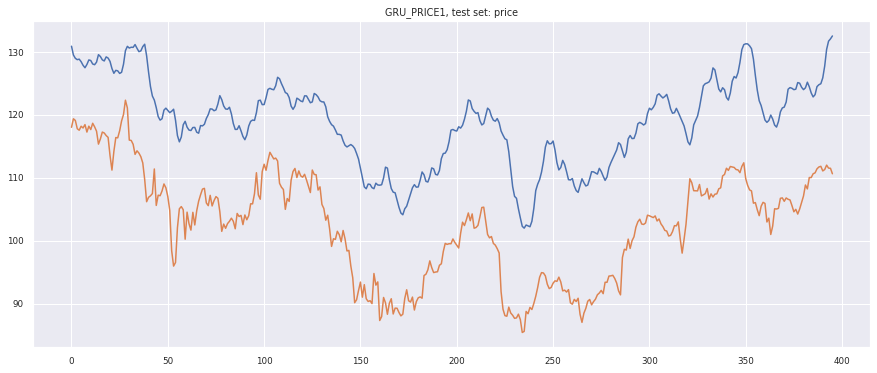

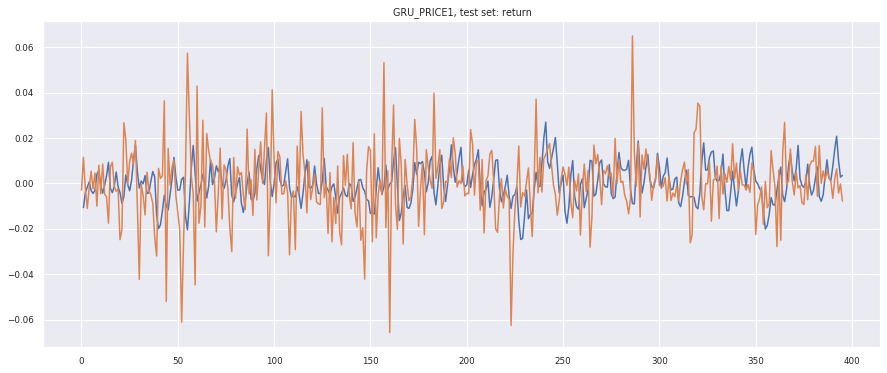

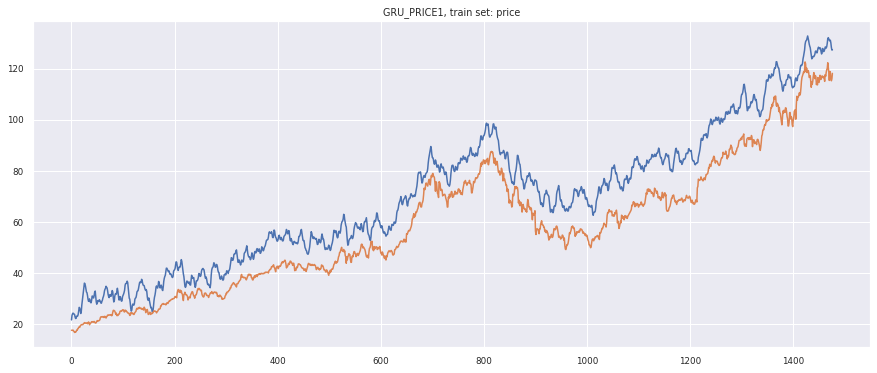

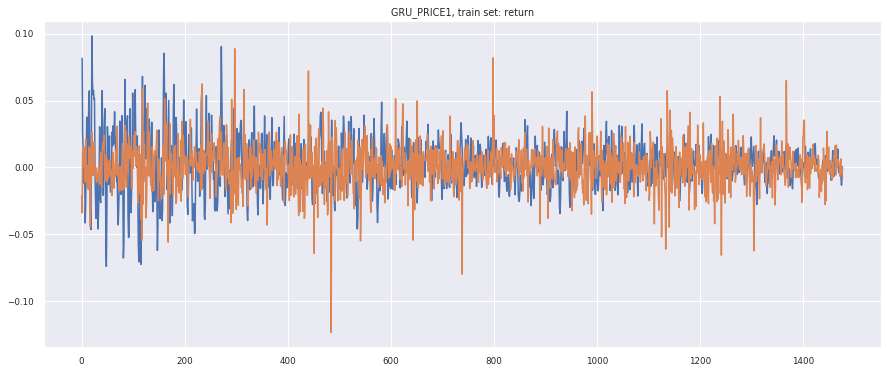

In test set, mse is 0.13057; In train set, mse is 0.89684


In [26]:
# load data
data = Load_data(DATA_PATH)
data = Feature_Engineering(data)
data = data[2200:]
data.head()

# split data into train and test
train, test, base = Data_Split(data, trainset_rate = 0.8, aim_feature = 'Adj Close') 
x_train, y_train, x_test, y_test, x_valid ,y_valid = Data_Construct(train, test, DATA_LENGTH=20, N=len(data.columns))

GRU_PRICE1 = GRU_Model(learn_rate=0.0005, batch=256,opt="rmsprop")

Test_Result_PRICE(GRU_PRICE1, data, x_train, x_test, y_train, y_test, base, try_train = True,title = "GRU_PRICE1")

- Comment
1. this one looks good in shape of price, but bad in return's mse.

data aiming to Adj Close split done!

x_train.shape: (1477, 20, 17), x_test.shape: (396, 20, 17), x_valid.shape: (164, 20, 17)
Train on 1477 samples, validate on 164 samples
Epoch 1/50
1477/1477 [==============================] - 41s 28ms/sample - loss: 0.0198 - val_loss: 0.3056
Epoch 2/50
1477/1477 [==============================] - 4s 3ms/sample - loss: 0.0472 - val_loss: 0.0783
Epoch 3/50
1477/1477 [==============================] - 4s 2ms/sample - loss: 0.0168 - val_loss: 0.0164
Epoch 4/50
1477/1477 [==============================] - 4s 2ms/sample - loss: 0.0098 - val_loss: 0.0018
Epoch 5/50
1477/1477 [==============================] - 4s 2ms/sample - loss: 0.0068 - val_loss: 7.0698e-04
Epoch 6/50
1477/1477 [==============================] - 3s 2ms/sample - loss: 0.0055 - val_loss: 0.0014
Epoch 7/50
1477/1477 [==============================] - 4s 3ms/sample - loss: 0.0093 - val_loss: 0.0015
Epoch 8/50
1477/1477 [==============================] - 4s 3ms/sample - loss: 0.0057 - val_l

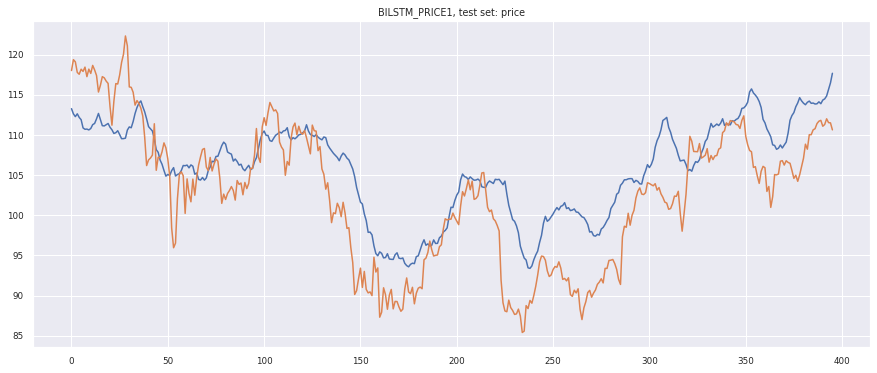

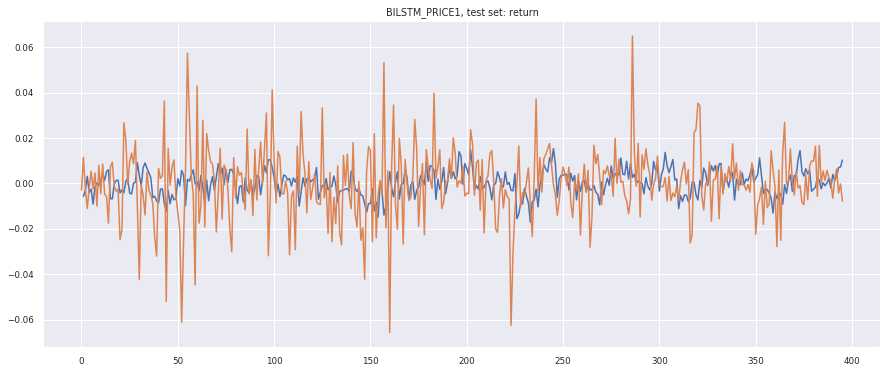

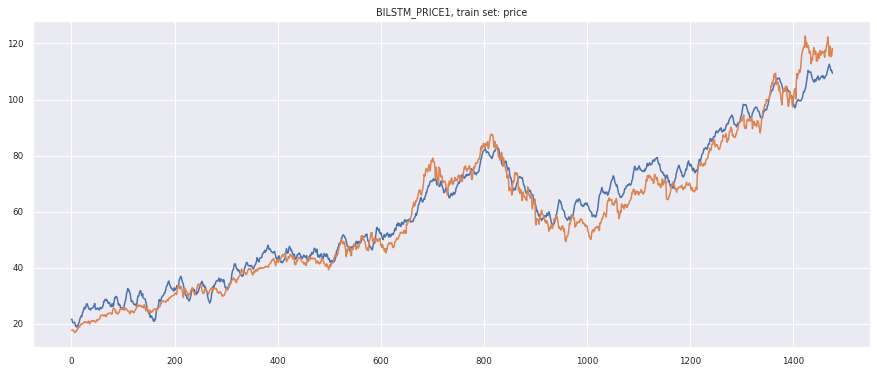

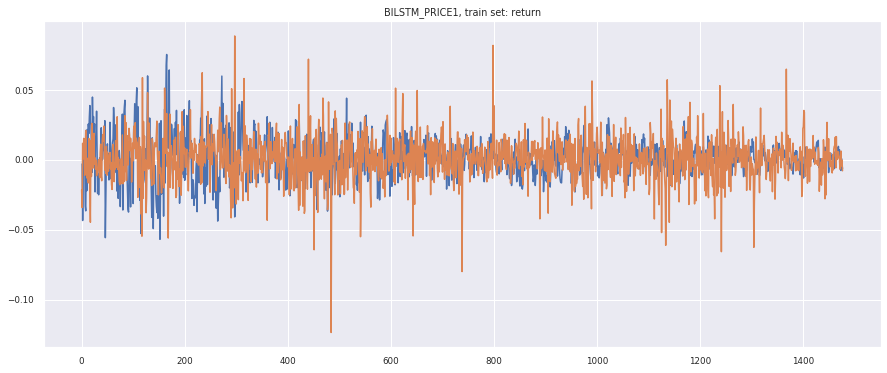

In test set, mse is 0.11310; In train set, mse is 0.67778


In [35]:
# load data
data = Load_data(DATA_PATH)
data = Feature_Engineering(data)
data = data[2200:]
data.head()

# split data into train and test
train, test, base = Data_Split(data, trainset_rate = 0.8, aim_feature = 'Adj Close') 
x_train, y_train, x_test, y_test, x_valid ,y_valid = Data_Construct(train, test, DATA_LENGTH=20, N=len(data.columns))

BILSTM_PRICE1 = BILSTM_Model(learn_rate=0.0003, batch=128,opt="rmsprop")

Test_Result_PRICE(BILSTM_PRICE1, data, x_train, x_test, y_train, y_test, base, try_train = True,title = "BILSTM_PRICE1")

- Comment
1. the last one is the best, considering volidation, train and test set.
2. I choose this model in pridecting price and then get return. the best parameters are 0.003 in learning rate and 128 in batch size

In [36]:
# save second model
modelName = "price_model"
model_path = os.path.join(".", modelName)
saveModel(BILSTM_PRICE1, model_path)

Model saved in directory ./price_model; create an archive of this directory and submit with your assignment.


## Predict the category to get the return
1. I use the previous funtion to turn the y into 8 categories, in that case I can do classification now.
2. I use Random forest to do it. At first I want to use the LSTM, but it seems not suitable for classification. I also try just use three dense layer, but result is bad.
3. The Random forest's result is not so good, the mse is large. But it does give some result. Unluckly, I finnal find I can not save Random Forest model. So I didn't add it in my final result.

In [0]:
data = Load_data(DATA_PATH)
data = Feature_Engineering(data)

data['return,t+1'] = data['return,t'].shift(-1).apply(lambda x:tran_class(x))
data['return,t-1'] = data['return,t'].shift(1)
data['return,t-2'] = data['return,t'].shift(2)
data['return,t-3'] = data['return,t'].shift(3)
data['return,t-4'] = data['return,t'].shift(4)
data['return,t-5'] = data['return,t'].shift(5)

data = data[2200:]
data.head()

,Adj Close,Volume,"return,t",year,month,day,weekday,vol,daily_range1,daily_range2,ma5,ma20,RSI,beat_market,Alpha1,Alpha2,Aplha3,"return,t+1","return,t-1","return,t-2","return,t-3","return,t-4","return,t-5"
2200,12.4424,402341100.0,-0.082662,2008,10,2,4,0.059005,0.087900,0.079021,13.83160,16.662175,27.478217,-0.046388,0.632750,-0.016640,-0.284165,1,-0.039949,0.079809,-0.179195,-0.027971,0.025015
2201,12.0658,573599600.0,-0.030267,2008,10,3,5,0.058974,0.125198,0.071392,13.05672,16.269945,28.452460,-0.016767,0.813592,-0.288296,22.025000,6,-0.082662,-0.039949,0.079809,-0.179195,-0.027971
2202,12.1988,526854300.0,0.011023,2008,10,6,1,0.059356,0.128398,-0.062971,12.87972,15.898410,29.590264,0.061957,0.808726,-0.681246,46.210526,0,-0.030267,-0.082662,-0.039949,0.079809,-0.179195
2203,11.0826,469693000.0,-0.091501,2008,10,7,2,0.061375,0.141091,0.126963,12.27064,15.509850,29.388113,-0.046715,0.760408,-0.030417,-0.369748,5,0.011023,-0.030267,-0.082662,-0.039949,0.079809
2204,11.1609,551935300.0,0.007065,2008,10,8,3,0.061739,0.124300,-0.043190,11.79010,15.125640,25.401134,0.032258,0.740049,-0.309472,-0.160819,2,-0.091501,0.011023,-0.030267,-0.082662,-0.039949


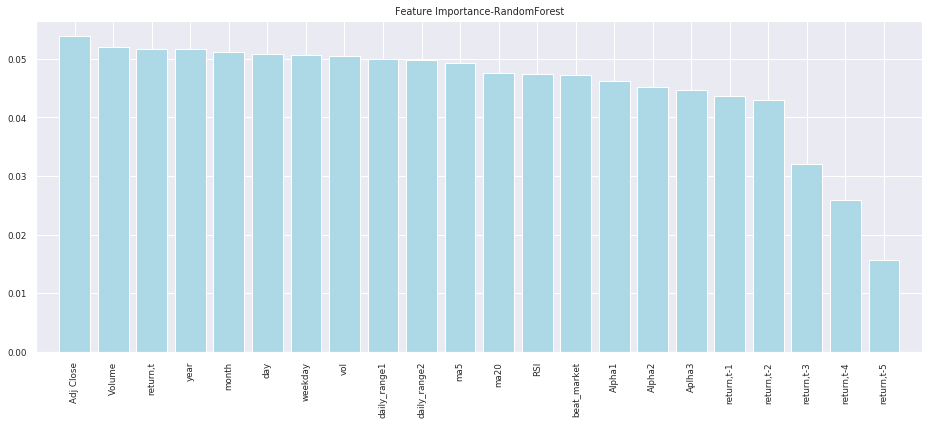

In [0]:
# set data
temy = data['return,t+1']
temx = data.copy()
del temx['return,t+1']
feat_labels = temx.columns[:]
length = int(0.8*len(data))

x_train_c, x_test_c = temx[:length],temx[length:]
y_train_c, y_test_c = temy[:length],temy[length:]

# built model
RF1 = RandomForestClassifier(n_estimators=400,max_depth=15,n_jobs=-1,random_state=0)
RF1.fit(x_train_c,y_train_c)

# print importance
importances = RF1.feature_importances_
indices=np.argsort(importances)[::-1]
# print photo
f, ax = plt.subplots(figsize=(13, 6))
plt.title('Feature Importance-RandomForest')
plt.bar(range(temx.shape[1]),importances[indices],color='lightblue',align='center')
plt.xticks(range(temx.shape[1]),feat_labels,rotation=90)
plt.xlim([-1,temx.shape[1]])
plt.tight_layout()
plt.show()

[[ 1  0  0  0  0  1  0  5  0]
 [ 0  0  6  0  0  7  2 19  0]
 [ 2  0  8  2  0 10  5 24  0]
 [ 3  0  7  1  0 15  5 49  0]
 [ 0  0 16  0  0 11  3 39  0]
 [ 2  0 10  1  0 11  4 40  0]
 [ 6  0  9  1  0 11  5 47  0]
 [ 0  0  5  0  0  0  4 13  0]
 [ 0  0  1  0  0  2  0  3  0]] 



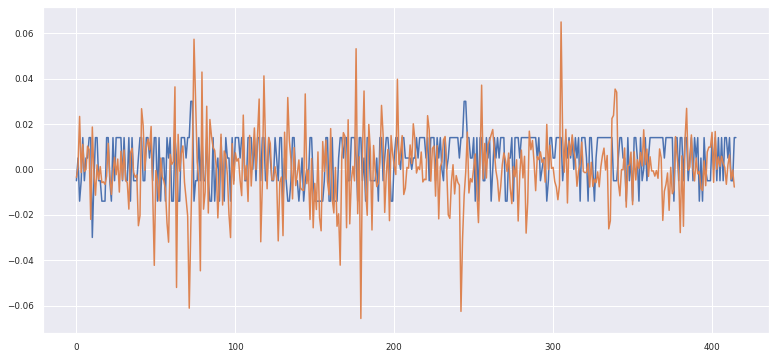


 mse in test set is : 0.157765633344658


In [0]:
# use the value to replace the catogory
def De_tran_class(ret):
    if ret == 0: return -0.05
    elif ret == 1: return -0.03
    elif ret == 2: return -0.014
    elif ret == 3: return -0.005
    elif ret == 4: return 0
    elif ret == 5: return 0.005
    elif ret == 6: return 0.014
    elif ret == 7: return 0.03
    else: return 0.05

# prediction
pre_ret = pd.Series(RF1.predict(x_test_c))
# confusion_matrix
print(confusion_matrix(y_test_c, y_pred),"\n")
# get the mse
pre_ret = pre_ret.apply(lambda x:De_tran_class(x))
y_ret = np.array((data['return,t'].shift(-1)[-len(pre_ret):]))
mse1 = sum((pre_ret - y_ret).apply(lambda x:x**2).dropna())
plt.subplots(figsize=(13, 6))
plt.plot(np.array(pre_ret))
plt.plot(y_ret)
plt.show()
print("\n mse in test set is :", mse1)


- Comment
1. RF has kind of large mse, but it is still a solution.
2. big mse may becasue I use a const value to replace the catogory.
3. I dont add it in the final model

### Final model
1. final model is 50% in ret_model and 50% in price_model. 
2. the first one can give mean, the second one can give volitility, so I combine them together.

### Pridction
1. I set some funtion to read the data in hold out
2. I cannot use the mymodel function... use I just use the code without function
3. To do new prediction, please change the Datapath1,2

In [0]:
import os
from tensorflow.keras.models import load_model
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model


def ADD_STOCKS1(df,DATA_PATH):
    files= os.listdir(DATA_PATH) 
    for file in files:
        if file != 'AAPL.csv':
            name = file.split('.')[0]
            tem = pd.read_csv(os.path.join(DATA_PATH, file))['Adj Close']
            # only the stock has data on 2008 can be added in
            if len(tem.dropna()) >= len(df[2200:]):
                df[name] = tem
    return df

def ADD_STOCKS2(df,DATA_PATH,stocklist):
    files= os.listdir(DATA_PATH)
    for file in files:
        name = file.split('.')[0]
        if name in stocklist:
            df[name] = pd.read_csv(os.path.join(DATA_PATH, file))['Adj Close']
    return df


def Data_Set_Outhold(train_data, test_data, aim_feature,DATA_LENGTH=20):
    # store base, because we need it to Destardize our output
    base = train_data[aim_feature].values.reshape(-1,1)
    # standardize return
    sc = MinMaxScaler(feature_range = (0, 1)).fit(base)
    # begining part is train set, ending part is test set
    train = sc.transform(test_data[aim_feature].values.reshape(-1,1))

    for feature in list(train_data.columns):
        if (feature != aim_feature):
            sc = MinMaxScaler(feature_range = (0, 1)).fit(train_data[feature].values.reshape(-1,1))
            train = np.concatenate((train, sc.transform(test_data[feature].values.reshape(-1,1))), axis=1)

    x_train,y_train = [],[]
    for i in range(DATA_LENGTH, train.shape[0]):    # for train set
        x_train.append(train[i-DATA_LENGTH:i,:])  # [i-DATA_LENGTH:i] will be in x
        y_train.append(train[i,0])   # [i] will be the one after train, put it in y

    x_train = np.array(x_train)
    y_train = np.array(y_train).reshape(-1,1)

    print("data aiming to {s} split done!\n".format(s = aim_feature))
    return x_train,y_train, base

def Load_data(DATA_PATH):
    df = pd.read_csv( os.path.join(DATA_PATH, "AAPL.csv") )
    # delete duplications
    df = df.drop_duplicates()
    # get return
    df['return,t'] = df['Adj Close']/df['Adj Close'].shift(1) - 1
    return df

# Feature Engineering by the AAPL's historical data
def Feature_Engineering(df,DATA_PATH):
    # get SPY and SPY's return
    df['SPY'] = pd.read_csv( os.path.join(DATA_PATH, "SPY.csv"))['Adj Close']
    df['return,spy'] = df['SPY']/df['SPY'].shift(1) - 1

    # calendar factors
    df['year'] = df.Dt.apply(lambda x:int(x.split('-')[0]))
    df['month'] = df.Dt.apply(lambda x:int(x.split('-')[1]))
    df['day'] = df.Dt.apply(lambda x:int(x.split('-')[2]))
    df['Dt'] = pd.to_datetime(df.Dt)
    df['weekday'] = df.Dt.apply(lambda x:x.weekday()+1)

    # volatility factors: volatility, daily change
    df['vol'] = np.log((df['return,t']+1)).rolling(21).std()
    df['daily_range1'] = df['High']/df['Low'] - 1
    df['daily_range2'] = df['Open']/df['Close'] - 1

    # momentum & reversion factors
    df['ma5'] = df['Adj Close'].rolling(5).mean()
    df['ma20'] = df['Adj Close'].rolling(20).mean()
    df['rise14'] = df['return,t'].apply(lambda x:max(x,0)).rolling(14).sum()
    df['fall14'] = df['return,t'].apply(lambda x:max(-x,0)).rolling(14).sum()
    df['RSI'] = df['rise14']/(df['rise14'] + df['fall14'])*100

    # Worldquant alpha
    df['beat_market'] = df['return,t'] - df['return,spy']
    df['Alpha1'] = -1*df['Adj Close'].rolling(10).corr(df['Volume'])
    df['Alpha2'] = -1*(df['Low'] - df['Close'])*df['Open']**5/((df['Low'] - df['High'])*df['Close']**5+0.01)
    df['Aplha3'] = -1*((df['Close'] - df['Low']) - (df['High'] - df['Close']))/(df['Close'] - df['Low']+0.01)
    df['Aplha3'] = df['Aplha3'].shift(9)

    # rename columns
    del df['Factor'],df['Close'],df['Div'],df['rise14'],df['fall14'],df['High'],df['Open'],\
                  df['Low'],df['Dt'],df['return,spy'],df['SPY']

    return df

In [0]:
DATA_PATH1 = "./Stock-Price-Prediction/data/final_project" 
DATA_PATH2 = "./Stock-Price-Prediction/stock_012017_012018"

# use this one when make new prediction
#DATA_PATH1 = "./data/final_project" 
#DATA_PATH2 = "./stock_012017_012018"

modelName1 = "ret_model"
model_path1 = os.path.join(".", modelName1)

modelName2 = "price_model"
model_path2 = os.path.join(".", modelName2)

In [39]:
# I cannot use the funtion... I don't know way

# YOU MAY NOT change model after this statement !
model1 = loadModel(model_path1)
model2 = loadModel(model_path2)

# It should run model to create an array of predictions; we initialize it to the empty array for convenience
predictions = []

# We need to match your array of predictions with the examples you are predicting
# The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
# For Bankruptcy: the Id column
# For Stock prediction: the date on which you are making a prediction
ids = []

# YOUR CODE GOES HERE
# load and process data
# model1

# YOU MAY NOT change model after this statement !
model1 = loadModel(model_path1)
model2 = loadModel(model_path2)

# It should run model to create an array of predictions; we initialize it to the empty array for convenience
predictions = []

# We need to match your array of predictions with the examples you are predicting
# The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
# For Bankruptcy: the Id column
# For Stock prediction: the date on which you are making a prediction
ids = []

# YOUR CODE GOES HERE
# load and process data
# model1
data1 = Load_data(DATA_PATH1)
data1 = Feature_Engineering(data1,DATA_PATH1)
data1 = ADD_STOCKS1(data1,DATA_PATH1)
data1 = data1[2200:]
stocklist = data1.columns[-21:]

data2 = Load_data(DATA_PATH2)
date = data2.Dt
data2 = Feature_Engineering(data2,DATA_PATH2)
data2 = ADD_STOCKS2(data2,DATA_PATH2,stocklist=data1.columns[-21:])
data2 = data2.dropna()

x_train_set, y_train_set, base_set = Data_Set_Outhold(data1, data2, aim_feature='return,t', DATA_LENGTH=20 )

# prediction
pre1 = model1.predict(x_train_set)
sc = MinMaxScaler(feature_range = (0, 1)).fit(base_set)
pre1 = list(sc.inverse_transform(pre1).reshape(-1))

ids = date[-len(y_train_set-1):]

# model2
data1 = Load_data(DATA_PATH1)
data1 = Feature_Engineering(data1,DATA_PATH1)
data1 = data1[2200:]

data2 = Load_data(DATA_PATH2)
data2 = Feature_Engineering(data2,DATA_PATH2)
data2 = data2.dropna()

x_train_set, y_train_set, base_set = Data_Set_Outhold(data1, data2, aim_feature='return,t', DATA_LENGTH=20 )

# prediction
pre2 = model2.predict(x_train_set)
sc = MinMaxScaler(feature_range = (0, 1)).fit(base_set)
pre2 = pd.Series(sc.inverse_transform(pre2).reshape(-1))
pre2 = list((pre2/pre2.shift(1)-1).dropna())

# combine 2 model with equal weight
predictions = list(map(lambda x,y:(x+y)/2,pre1[1:],pre2))

print(ids[:5], predictions[:5])

data aiming to return,t split done!

data aiming to return,t split done!



[0.0023458146024495363,
 -0.00045396049972623587,
 -0.014311521896161139,
 -0.0025060517946258187,
 -0.01462637516669929]